# 0: rappel structure des données:  
Grey images are stored in memory as 2D arrays, color images as a 3D arrays

io.imread returns a np.array of shape (hauteur, largeur, 3) or (hauteur, largeur)
* image [ 0 , 0 ] : upper left corner
* image [ 0 , n ] : upper right corner
* image [ n , 0 ] : lower left corner
* image [ : , 0:n/2 ] : left half of picture

size of video picture: 1080, 1920

doc: https://docs.opencv.org/master, mostly in the features2D and calib3d modules

# 1: Fonctions et images de bases

In [1]:
%matplotlib inline
# %matplotlib widget

import numpy as np
import math, random
import cv2 as cv2 # opencv computer vision library
from skimage import io # for io.imread
from matplotlib import pyplot as plt # ploting

import mediapipe as mp  # human pose detection

import ast # string representation of list to list using ast.literal_eval()

# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
plan_face = io.imread('data/01.18.42.183_front.png')
plan_face_crop = plan_face[0:700, 300:1300]
plan_cote_1 =  io.imread('data/01.18.47.450_side1.png')
plan_cote_2 =  io.imread('data/01.18.52.000_side2.png')

travel_front = io.imread_collection ('data/travel_front/*')

# autre
plan_face_autre = io.imread('data/other/front.jpg')
plan_cote_autre = io.imread('data/other/side.jpg')
plan_shema = io.imread('data/other/shematic.jpg')

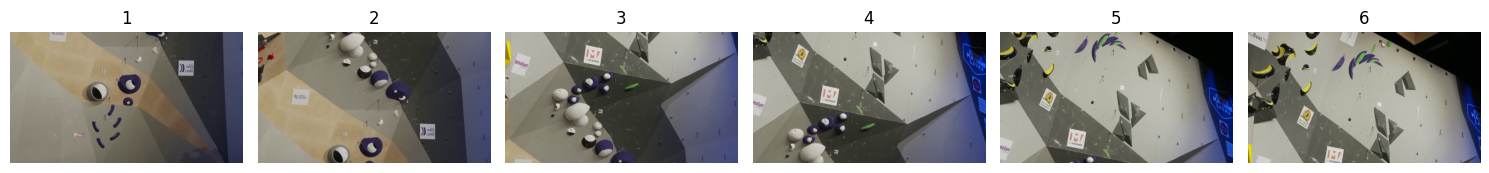

In [3]:
def imshow(images, titles="123456789", callback = None, nrows = 0, ncols=0, figsize = (15,4)):
    """Plot a multiple images with titles.

    Parameters
    ----------
    images : image list
    titles : title list
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    if ncols == 0 and nrows == 0:
        ncols = len(images)
        nrows = 1
    if ncols == 0:
        ncols = len(images) // nrows
    if nrows == 0:
        nrows = len(images) // ncols

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = figsize)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() # optional

    if callback is not None:
        def onclick(event):
            [i],[j] = np.where(axeslist == event.inaxes)
            callback(axeslist, [i,j], [event.xdata, event.ydata])

        # Create an hard reference to the callback not to be cleared by the garbage collector
        ka = fig.canvas.mpl_connect('button_press_event', onclick)
    return axeslist

axeslist = imshow (travel_front, figsize=(15,2))

# 2: reconstruction de la voie en 2d grâce au travelling

In [4]:
def extract_key_points(img1, img2=None):
    akaze = cv2.AKAZE_create()
    kp1, des1 = akaze.detectAndCompute (img1,None)
    if img2 is None:
        return kp1, des1
    kp2, des2 = akaze.detectAndCompute (img2,None)
    return kp1, des1, kp2, des2

def showKeyPoints(img1, kp1, img2, kp2):
    img_1 = cv2.drawKeypoints( img1, kp1, None) 
    img_2 = cv2.drawKeypoints( img2, kp2, None) 
    imshow([img_1, img_2],["left", "right"])

def match_key_points(kp1, des1, kp2, des2):
    bf = cv2.BFMatcher()
    # Match descriptors.
    matches = bf.match(des1,des2)
    # Sort them in the order of their distance.
    return sorted(matches, key = lambda x:x.distance)

def showMatches(img1, kp1, img2, kp2, matches, name="matches"):
    img = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    imshow([img],[name])

def findHomography(matches, keypoint1, keypoint2):
    src_pts = np.array([keypoint1[matches[m].queryIdx].pt for m in range(len(matches))])
    dst_pts = np.array([keypoint2[match.trainIdx].pt for match in matches])
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    inliers = [matches[m] for m in range(len(mask)) if mask[m]==1]
    return H,inliers

array([[<Axes: title={'center': 'panorama'}>]], dtype=object)

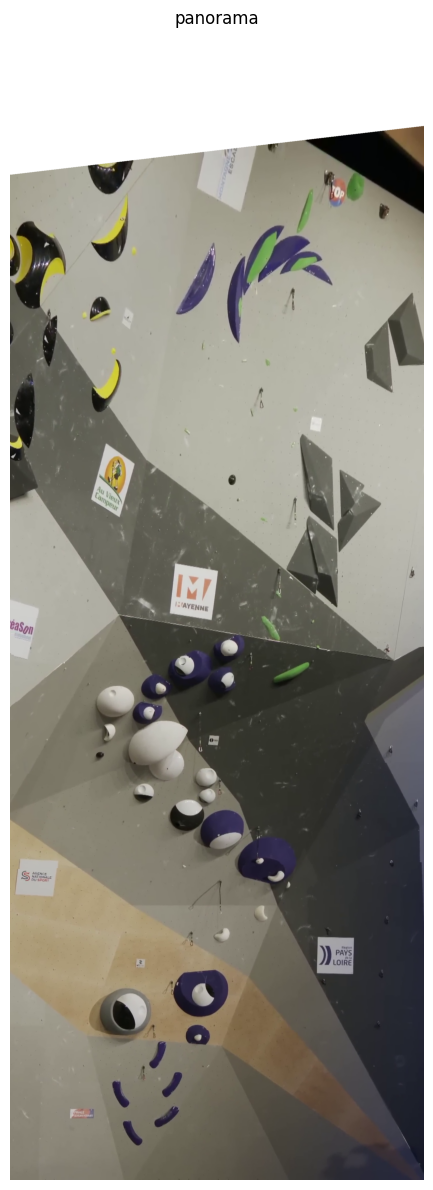

In [5]:
def panorama_pipeline (images,final_size, location="ul"):
    x,y, = final_size
    nb_img = len(images)
    img_pano = images[0]

    y1,x1, _ = images[0].shape
    H = np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])
    # location = where to place first image
        # first letter = up/middle/bottom
        # second letter = left/middle/right
    if location[1]=='m':
        H[0][2] = (x1-x)/2
    if location[1]=='r':
        H[0][2] = x1-x
    if location[0]=='m':
        H[1][2] = (y1-y)/2
    if location[0]=='b':
        H[1][2] = y1-y

    img_pano =  255*np.ones((y, x, 3),dtype=np.uint8)
    img_pano = cv2.warpPerspective(images[0], H, final_size, img_pano, borderMode=cv2.BORDER_TRANSPARENT, flags=cv2.WARP_INVERSE_MAP)

    for i in range (1,nb_img):
        img1= images[i-1]
        img2= images[i]
        kp_1, des_1, kp_2, des_2 = extract_key_points(img1, img2)
        matches_pipeline = match_key_points(kp_1, des_1, kp_2, des_2)
        H2, inliers = findHomography(matches_pipeline, kp_1, kp_2)
        H=np.matmul(H2, H)
        img_pano = cv2.warpPerspective(img2, H, final_size, img_pano, borderMode=cv2.BORDER_TRANSPARENT, flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return img_pano

panorama = panorama_pipeline(travel_front,(3000,4000), "bm")
panorama = panorama[:,860:2300]
imshow([panorama], ["panorama"] , figsize=(5,12))


# 3: Reconstruction de la voie en 3d
L'objectif est de détecter les facettes sur différentes prises de vue et d'en déduire une triangulation du mur

## 3.1 Extraction des facettes

### 3.1.1 tentative avec Canny et détecteur de lignes

array([[<Axes: title={'center': 'source'}>,
        <Axes: title={'center': 'Canny'}>,
        <Axes: title={'center': 'Hough detection'}>]], dtype=object)

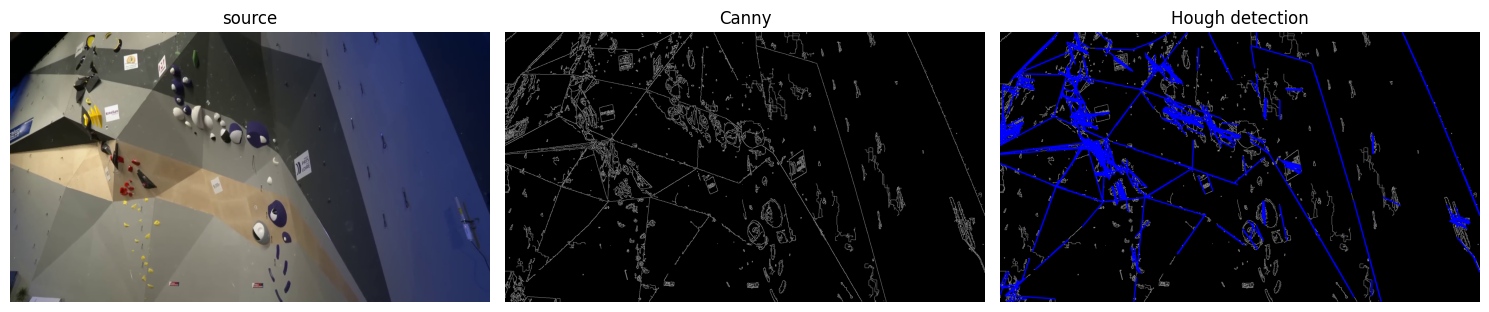

In [6]:
plt.close()
img = plan_cote_1

edges = cv2.Canny(img, 0, 40, None, 3)

# Copy edges to the images that will display the results in BGR
final = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 40, None, 60, 15)

if lines is not None:
    for i in range(0, len(lines)):
        l = lines[i][0]
        cv2.line(final, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

imshow([img, edges, final], ["source", "Canny", "Hough detection"])

### 3.1.2 Extraction à la main
pointage des facettes à la main dans différentes images

In [7]:
def draw_point(axe, point, color=None):
    # draw the clicked point
    if color is None:
        color = np.random.rand((3))
    axe.scatter([point[0]], [point[1]], color=[color], s=400, marker='+')

def draw_points(axes, points):
    # draw the points saved in the list
    counter = 0
    for i in range(len(points[0])):
        color = np.random.rand((3))
        for j in range(len(points)):
            draw_point(axes[j], points[j][i], color)
            axes[j].annotate(str(i), points[j][i] )

def onclick_get_coord(axeslist, ij, p):
    i = ij[0] # row of clicked image
    j = ij[1] # column
    draw_point(axeslist[i, j], p)
    print(p)

def get_points_from_file(file):
  f = open(file, "r")
  L = []
  for line in f:
    coords = ast.literal_eval(line)
    L.append(coords)
  return L

def get_int_points_from_file(file):
  f = open(file, "r")
  L = []
  for line in f:
    coords = ast.literal_eval(line)
    L.append([int(coord) for coord in coords])
  return L

points_front = get_points_from_file("data/other/front.txt")
points_side = get_points_from_file("data/other/side.txt")

points_int_front = get_int_points_from_file("data/other/front.txt")
points_int_side = get_int_points_from_file("data/other/side.txt")

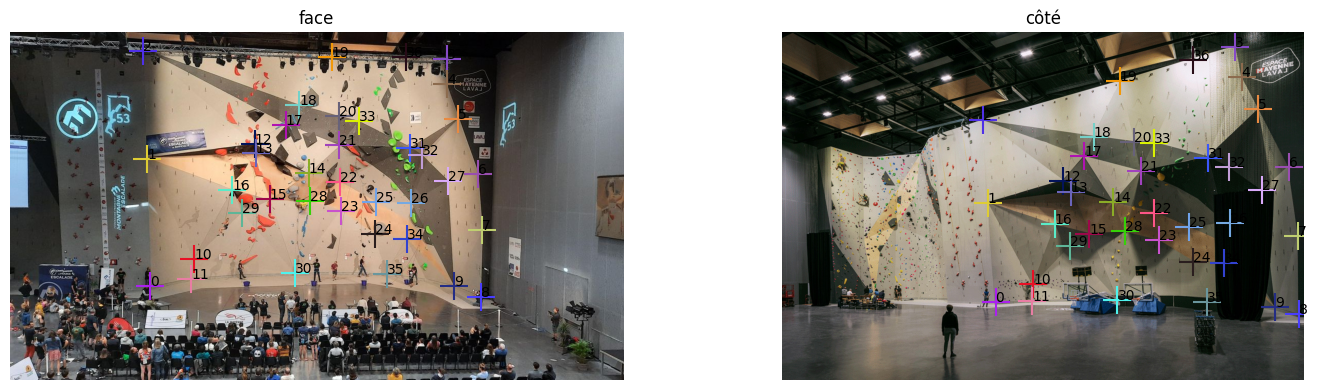

In [8]:
axeslist = imshow( [plan_face_autre, plan_cote_autre], ['face', 'côté'])
draw_points([axeslist[0,0], axeslist[0,1]], [points_front, points_side])


True

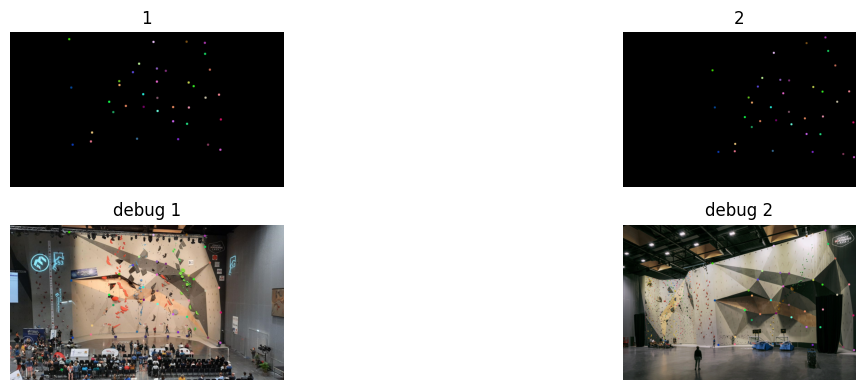

In [9]:
img_synth_face = np.zeros_like(plan_face_autre)
img_synth_cote = np.zeros_like(plan_cote_autre)

debug_face = np.copy(plan_face_autre)
debug_cote = np.copy(plan_cote_autre)

for i in range (len(points_front)):    
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.circle(img_synth_face, points_int_front[i], 5, color, -1)
    cv2.circle(img_synth_cote, points_int_side[i], 5, color, -1)
    cv2.circle(debug_face, points_int_front[i], 5, color, -1)
    cv2.circle(debug_cote, points_int_side[i], 5, color, -1)

imshow([img_synth_face, img_synth_cote, debug_face, debug_cote], ["1","2","debug 1", "debug 2"], nrows=2)
cv2.imwrite('data/synth/images/cote.png', img_synth_cote)
cv2.imwrite('data/synth/images/face.png', img_synth_face)

## 3.2 computing fundamental matrix from matched points

In [10]:
points_front = np.array(get_points_from_file("data/other/front.txt"))
points_side = np.array(get_points_from_file("data/other/side.txt"))

F12, mask = cv2.findFundamentalMat(points_front, points_side) # method= cv2.FM_RANSAC

F = [F12, F12.T]

print(F12)

f = 2500
K_front = np.array([[f,0,0], [0,f,0], [plan_face_autre .shape[0]/2,plan_face_autre.shape[1]/2,1]])   # guess of intrinsic matrix
K_side = np.array([[f,0,0], [0,f,0], [plan_cote_autre.shape[0]/2,plan_cote_autre.shape[1]/2,1]])   # guess of intrinsic matrix

E = K_front.T @ F12 @ K_side

print(E)

[[-2.37862643e-05  4.07503931e-05  3.15501691e-02]
 [-4.41952806e-06 -4.86240926e-06 -4.67018788e-02]
 [-1.57948047e-02  2.23403048e-02  1.00000000e+00]]
[[1.41409658e+05 2.51719809e+05 4.18875423e+02]
 [1.55080933e+05 3.01681210e+05 4.83245303e+02]
 [3.30512988e+02 6.10850762e+02 1.00000000e+00]]


### 3.2.1 copie du TD4: matrice fondamentale et lignes épipolaires

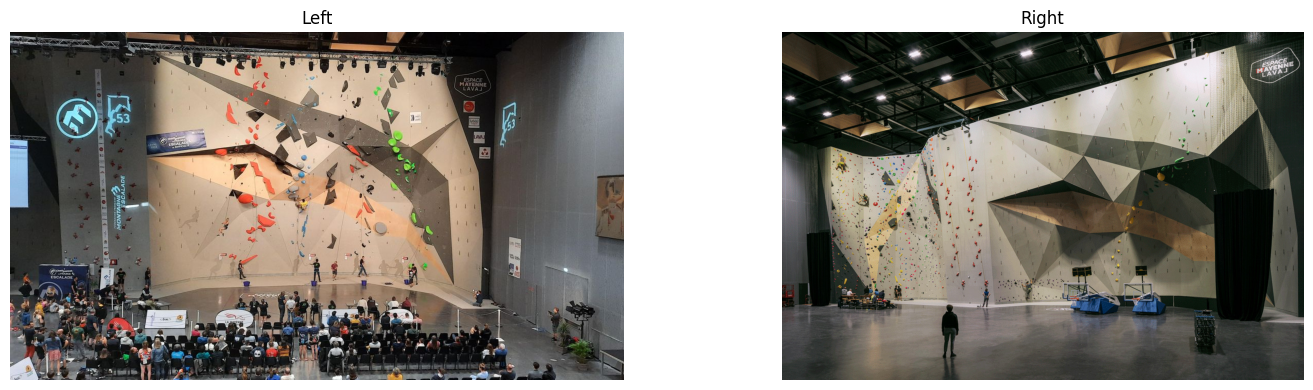

In [11]:
def get_epipolar_line(point, f):
    P = np.array( [point[0], point[1], 1])
    return np.dot(f, P)

def get_y_at_x(line, x):
    return -(line[0]*x +line[2])/line[1]
    
def draw_epipolar_line(axe1, axe2, point, f, color):
    l = get_epipolar_line(point, f)
    # to draw it, we need 2 arbitrary points,
    # let's take its intercept with x=0 and x=1
    x0 = 0
    x1 = 1
    p0 = [x0, get_y_at_x(l, x0)]
    p1 = [x1, get_y_at_x(l, x1)]
    axe2.axline(p0, p1, color=color)
    # draw the clicked point with the same color
    axe1.scatter([point[0]], [point[1]], color=[color], marker='+')


def onclick_draw_epipolar_line(axeslist, ij, p, text = None):
    i = ij[0] # == 0
    j = ij[1] # == 0 or 1 for left or right image
    # take a random color
    color = np.random.rand((3))
    draw_epipolar_line(axeslist[i, j], axeslist[i, 1-j], p, F[j], color)
    
axeslist = imshow( [plan_face_autre, plan_cote_autre], ['Left', 'Right'], onclick_draw_epipolar_line)

### 3.2.2 undistorting matrix

### 3.2.3 utilisation de la matrice fondamentale pour obtenir la perspective

In [12]:
proj_front =np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]])
retval, R, t, mask = cv2.recoverPose(E, points_front, points_side)
proj_side = np.concatenate((R,t), axis = 1)

print(proj_side)

d4_points = cv2.triangulatePoints(proj_front, proj_side, points_front.T, points_side.T)
d3_points = d4_points[:3] / d4_points[3]

print(d3_points.shape)

[[ 2.13093644e-01 -9.77029720e-01 -2.00621824e-03  1.37380405e-03]
 [ 9.77031768e-01  2.13092871e-01  5.93808323e-04  8.78530872e-04]
 [-1.52657575e-04 -2.08667573e-03  9.99997811e-01 -9.99998670e-01]]
(3, 37)


Problem:  
we don't have the intrinsic camera parameters -> we can only calculate the position up to a projective transformation
Is this the reason we get such a distorted image with points aligned along one axis ?

### 3.2.4 affichage de la structure 3d

TODO: 
* comprendre fonctionnement de cv2.triangulatePoints
* ou: tester une implémentation de triangulation perso (biblio ?)

TODO: comment afficher la triangulation en 3d ? 

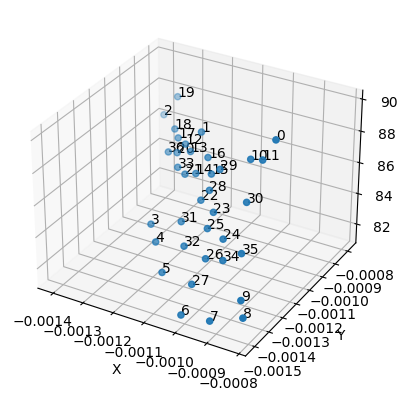

In [13]:
# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, and z coordinates from the points
x = [point[0] for point in d3_points]
y = [point[1] for point in d3_points]
z = [point[2] for point in d3_points]
# Plot the points
ax.scatter(d3_points[0], d3_points[1], d3_points[2])
for i in range(len(d3_points[0])):
    ax.text(d3_points[0][i],d3_points[1][i],d3_points[2][i],  str(i), size=10, zorder=1,color = 'k')

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()


# 4: detecting human pose with media pipe

Mediapipe gives the relative position of the person on the video.

We need its absolute position on the wall.

def extract_key_points(img1, img2=None):
    akaze = cv2.AKAZE_create()
    kp1, des1 = akaze.detectAndCompute (img1,None)
    if img2 is None:
        return kp1, des1
    kp2, des2 = akaze.detectAndCompute (img2,None)
    return kp1, des1, kp2, des2

def showKeyPoints(img1, kp1, img2, kp2):
    imshow([img_1, img_2],["left", "right"])

def match_key_points(kp1, des1, kp2, des2):
    return sorted(matches, key = lambda x:x.distance)

def showMatches(img1, kp1, img2, kp2, matches, name="matches"):
    img = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    imshow([img],[name])

def findHomography(matches, keypoint1, keypoint2):
    return H,inliers

In [14]:
# initialize Pose estimator
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

pose = mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

I0000 00:00:1702680197.865005    3977 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1702680197.871135    4434 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: Mesa Intel(R) UHD Graphics 620 (WHL GT2)


In [15]:

# create capture object
cap = cv2.VideoCapture('data/video/men1.mp4')

for i in range(750):
      cap.read()

counter = 0
while cap.isOpened():
      # read frame from capture object
      _, frame = cap.read()

      # convert the frame to RGB format
      rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

      # process the RGB frame to get the result
      results = pose.process(rgb_frame)
      # draw detected skeleton on the frame
      mp_drawing.draw_landmarks(
            frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
      # show the final output
      cv2.imshow('Output', frame)
      counter_str = str(counter)
      if counter < 10:
            counter_str = "0" + counter_str
      if counter < 100:
            counter_str = "0" + counter_str
      cv2.imwrite("data/video/posture/"+counter_str+".jpg", frame)
      counter += 1

      if results.pose_landmarks is not None:
            print(results.pose_landmarks)
            print("__________________________")

      if cv2.waitKey(1) == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


landmark {
  x: 0.5773410797119141
  y: 0.33232590556144714
  z: 0.275611937046051
  visibility: 0.9994657635688782
}
landmark {
  x: 0.5778021216392517
  y: 0.3197742700576782
  z: 0.2534368336200714
  visibility: 0.9997349381446838
}
landmark {
  x: 0.5751266479492188
  y: 0.31952548027038574
  z: 0.2535698711872101
  visibility: 0.9996997117996216
}
landmark {
  x: 0.5724245309829712
  y: 0.31945177912712097
  z: 0.2535099685192108
  visibility: 0.9996356964111328
}
landmark {
  x: 0.5865501165390015
  y: 0.3235284686088562
  z: 0.25346964597702026
  visibility: 0.9995040893554688
}
landmark {
  x: 0.5899429321289062
  y: 0.32594671845436096
  z: 0.2535194456577301
  visibility: 0.9994357228279114
}
landmark {
  x: 0.5937773585319519
  y: 0.32882389426231384
  z: 0.2535138428211212
  visibility: 0.9995410442352295
}
landmark {
  x: 0.5673018097877502
  y: 0.3284749686717987
  z: 0.17805825173854828
  visibility: 0.9997578263282776
}
landmark {
  x: 0.5982946157455444
  y: 0.34342035

In [16]:
pano_kps, pano_des = extract_key_points(panorama)

def match_pano(img):
    kps, des = extract_key_points(img)
    matches = match_key_points(kps, des, pano_kps, pano_des)
    H, _ = findHomography(matches, kps, pano_kps)
    showMatches(img, kps, panorama, pano_kps, matches)
    return H

array([[<Axes: title={'center': '1'}>]], dtype=object)

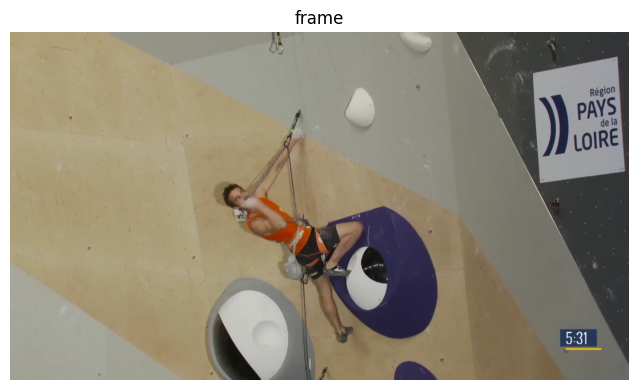

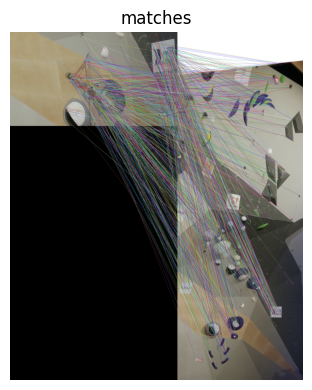

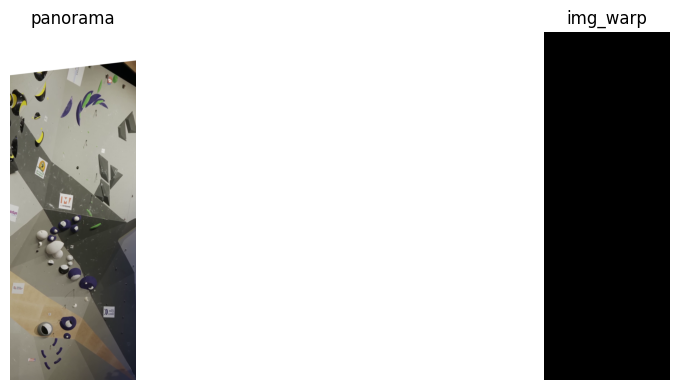

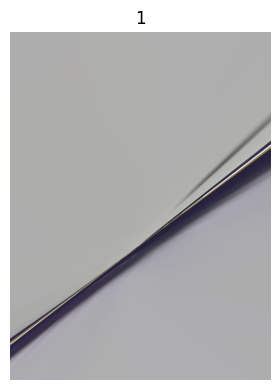

In [17]:
# create capture object
cap = cv2.VideoCapture('data/video/men1.mp4')

for i in range(1000):
      cap.read()

_, frame= cap.read()


# convert the frame to RGB format
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
imshow([frame], ["frame"])


H = match_pano(frame)

img_warp =  255*np.ones((panorama.shape[1], panorama.shape[0], 3),dtype=np.uint8)
img_warp = cv2.warpPerspective(frame, H, (panorama.shape[1], panorama.shape[0]), img_warp, borderMode=cv2.BORDER_TRANSPARENT, flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

imshow([panorama, img_warp], ["panorama", "img_warp"])

test = panorama_pipeline([panorama, frame],(3000,4000), "bm")
imshow([test])

# 5 Segmenting: détection des prises

array([[<Axes: title={'center': 'B'}>, <Axes: title={'center': 'G'}>,
        <Axes: title={'center': 'R'}>, <Axes: title={'center': 'H'}>,
        <Axes: title={'center': 'S'}>, <Axes: title={'center': 'V'}>]],
      dtype=object)

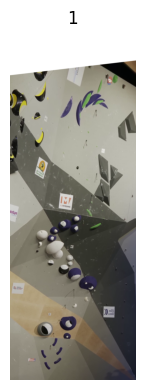

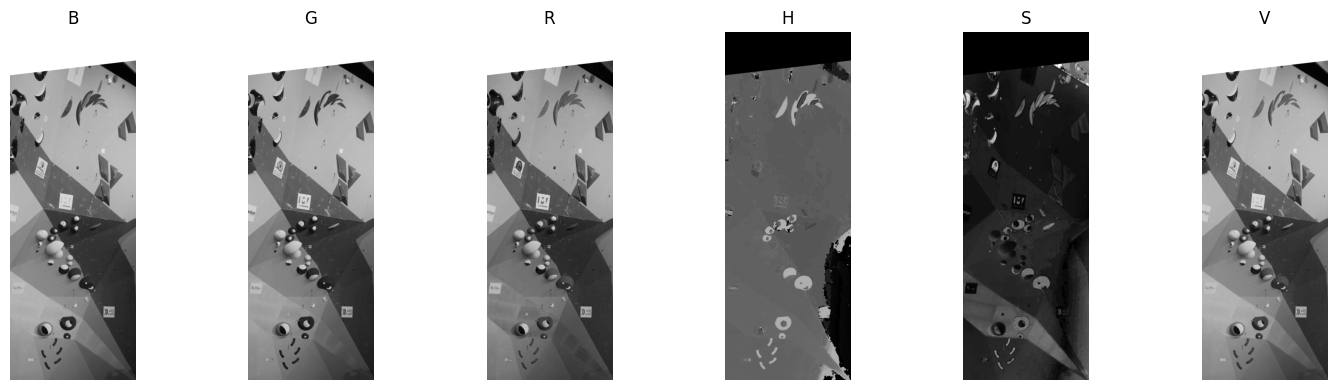

In [18]:
pano_hsv = cv2.cvtColor(panorama, cv2.COLOR_BGR2HSV)

imshow([panorama])
imshow([panorama[:,:,0], panorama[:,:,1], panorama[:,:,2], pano_hsv[:,:,0], pano_hsv[:,:,1], pano_hsv[:,:,2]], 
        "BGRHSV")

### 5.1.1 region based segmentation

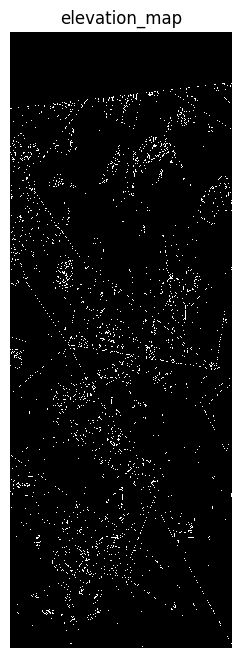

In [19]:
imm=pano_hsv[:,:,2]
elevation_map = cv2.Canny(imm, 0, 50, None, 3)

fig, ax = plt.subplots(figsize=(18,8))
ax.imshow(elevation_map, cmap='gray', interpolation='nearest')
ax.axis('off')
ax.set_title('elevation_map')
plt.show()


array([[<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>]],
      dtype=object)

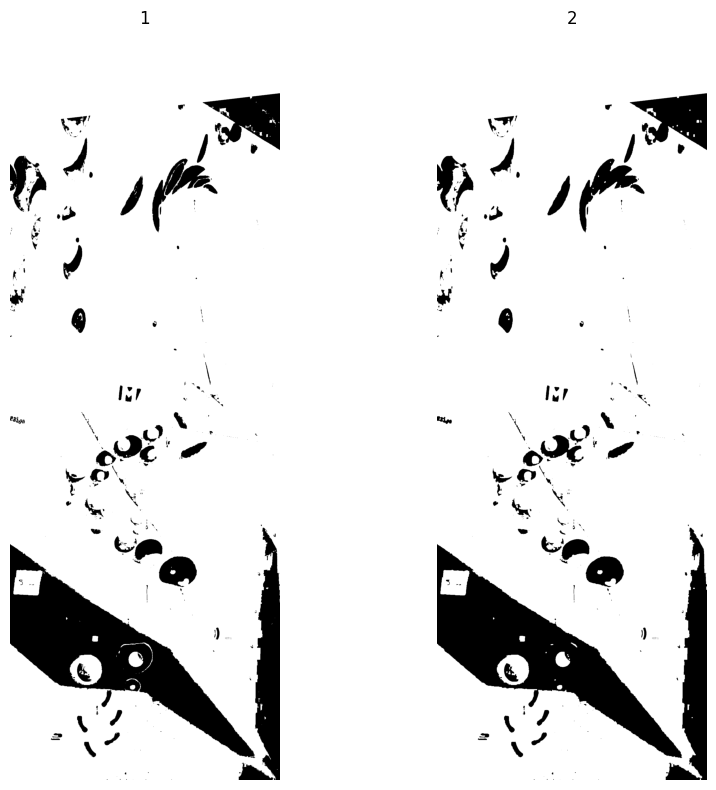

In [20]:


#Threshold Processing 
ret, bin_img = cv2.threshold(pano_hsv[:,:,1], 
                             0, 255,  
                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) 

# noise removal 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)) 
bin_img2 = cv2.morphologyEx(bin_img,  
                           cv2.MORPH_OPEN, 
                           kernel, 
                           iterations=2) 
imshow([bin_img, bin_img2], figsize=(10,8)) 


array([[<Axes: title={'center': 'sure bg'}>,
        <Axes: title={'center': 'dist'}>,
        <Axes: title={'center': 'sure foreground'}>,
        <Axes: title={'center': 'unknown'}>]], dtype=object)

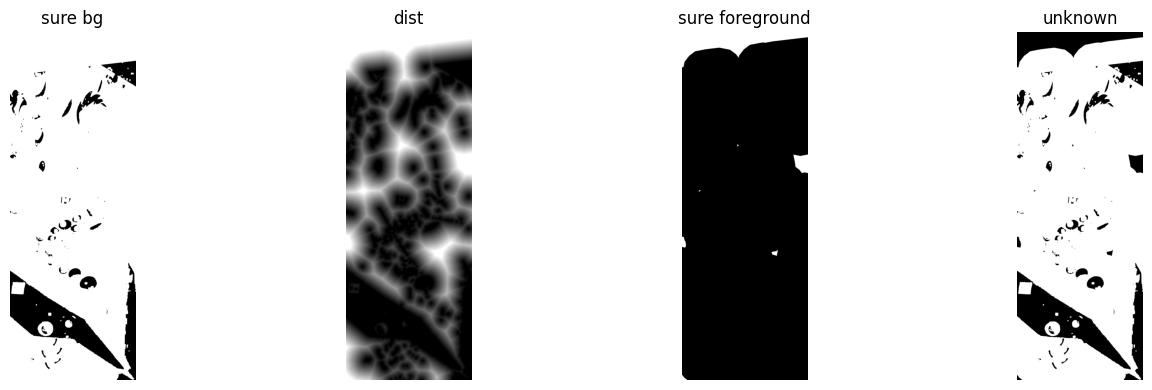

In [21]:
# sure background area 
sure_bg = cv2.dilate(bin_img2, kernel, iterations=3) 
  
# Distance transform 
dist = cv2.distanceTransform(bin_img2, cv2.DIST_L2, 5) 
  
#foreground area 
ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY) 
sure_fg = sure_fg.astype(np.uint8)   
  
# unknown area 
unknown = cv2.subtract(sure_bg, sure_fg) 

imshow([sure_bg, dist, sure_fg, unknown], ["sure bg", "dist", "sure foreground", "unknown"])


### 5.1.2 cluster based segmentation

array([[<Axes: title={'center': 'segmented_image'}>]], dtype=object)

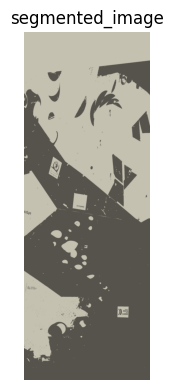

In [22]:
pixel_values = panorama.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

# number of clusters (K)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

# reshape back to the original image dimension
segmented_image = segmented_image.reshape(panorama.shape)

imshow([segmented_image], ["segmented_image"])